In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
#use_python("/home/vsevim/software/anaconda3/envs/R42/bin/python")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"

    # prj_name = "Screen2_101vecs"
    # # data_subdir_suffixes = "L1,L2,L3,L4"     
    # secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    # save_seurat_h5 = "YES"

}


In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated_wo_guide_calls.h5seurat")
updated_integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


In [6]:
ncol(seurat_combined)

[1] 27142

Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [7]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

In [14]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)
    df_guide_counts <- seurat[['sgRNA']]@counts
    DefaultAssay(seurat) <- "sgRNA"
    rowsums = rowSums(df_guide_counts)
    select_abundants = df_guide_counts[rowsums > min_guide_count, ]
    df_guide_counts = df_guide_counts[select_abundants, ]
    seurat[['sgRNA']]@counts = df_guide_counts
    plots = list()

    seurat <- NormalizeData(seurat, assay = "sgRNA", normalization.method = "CLR")
    seurat <- HTODemux(seurat, assay = "sgRNA", positive.quantile = 0.99)
    

    cat(green("Completed", library_name, "\n"))    
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    
}

Skipping guides with less than 50 counts
Running Lib_1 


ERROR: Error in df_guide_counts[select_abundants, ]: invalid or not-yet-implemented 'Matrix' subsetting


In [13]:
df_guide_counts

  [[ suppressing 33 column names 'AAACCCAAGAGCAGCT-1_1', 'AAACCCAAGCTTAAGA-1_1', 'AAACCCAAGGCTGTAG-1_1' ... ]]



132 x 7295 sparse Matrix of class "dgCMatrix"
                                                                             
CD13-1a       . 882    .    2 .   .  695    .    .   . 445    .    1   .    .
CD13-1b       . 593    .    . .   .  589    .    .   . 390  156    .   .    .
CD55-1a       .   .    1    . . 375   16    .    1   1   1    1    .   .    .
CD55-1b       .   .    .    . . 594   12    .    1   .   .  323    1   .    .
CD73-1a       .   .    .    1 .   .    2    .    .   .   .    .    1   .    .
CD73-1b       .   .    .    . .   .    1    .    .   .   1    .    .   .    .
FUBP1-1a    941  20    1    1 .   .  851    . 2010   .   .    .    .   .    .
FUBP1-1b      .   .    .    . .   .  679    .  484   1   .    .    .   .    .
C15orf40-1a   3   .    .    . .   1    .    .    .   .   .    .    .   .    .
C15orf40-1b   .   .    .    . .   .    .    1    .   .   .   11    .   .    .
MAFF-1a       1   .    .    . .   . 2304    .    .   .   .   32    1   .    1
MAFF-1b       .   

In [ ]:
seurat_sgRNA <- HTODemux(seurat_sgRNA, assay = "sgRNA", positive.quantile = 0.99)

ERROR: Error in HTODemux(seurat_sgRNA, assay = "sgRNA", positive.quantile = 0.99): Cells with zero counts exist as a cluster.


# Write thresholds to file

In [140]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)

if(save_seurat_h5 == "YES") {
    write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)
}

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,4
2,Lib_1,CD13-1b,4
3,Lib_1,CD55-1a,10
4,Lib_1,CD55-1b,5
5,Lib_1,CD73-1a,8
6,Lib_1,CD73-1b,3


In [141]:
head(df_thresholds)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,4
2,Lib_1,CD13-1b,4
3,Lib_1,CD55-1a,10
4,Lib_1,CD55-1b,5
5,Lib_1,CD73-1a,8
6,Lib_1,CD73-1b,3


In [142]:
#head(seurat_combined@misc$stats)
rownames(seurat_combined@misc$stats) <- seurat_combined@misc$stats$Library

In [144]:
#head(seurat_combined)

In [143]:
nrow(seurat_combined@meta.data[seurat_combined@meta.data$library == 'Lib_1', ])
seurat  <- subset(seurat_combined, subset = library == 'Lib_1')
#DefaultAssay(seurat) <- "sgRNA"
nrow(seurat@meta.data)



[1] 4475

[1] 4475

# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [145]:
### Load THRESHOLDS.tsv
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS


### Get the list of pertubed cells for each guide

In [146]:
perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds)

In [147]:
df_calls = enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls = as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell  <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)

In [148]:
df_calls_wide <- df_calls %>% 
    group_by(cell) %>% 
    summarise(
        guide_calls = paste(unique(guide), collapse = '|'), 
        plasmid_calls = paste(unique(plasmid), collapse = '|')
    )

In [149]:
df_calls_wide$n_guides   <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide = as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL

In [150]:
head(df_calls_wide,2)

,guide_calls,plasmid_calls,n_guides,n_plasmids
,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAAGGGAT-1_5,DE28-2a,DE28-2,1,1
AAACCCAAGACGTCCC-1_7,PLIN3-1b|DE10-1a|DE27-2a,PLIN3-1|DE10-1|DE27-2,3,3


### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [151]:
seurat_backup = seurat_combined
#seurat_combined = seurat_backup

In [152]:
cols2rename = c('PS_call', 'construct_call', 'target_call', 'nCalled_Constructs', 'nPS_calls', 'nCalled_sgRNA_UMIs')
df_dummy = seurat_combined@meta.data
for(i in 1:length(cols2rename)) {
    colname = cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0('cellranger_', colname) 
}

#### Merge calls with the Seurat object

In [153]:
df_dummy = merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
original_row_names <- rownames(seurat_combined@meta.data)
seurat_combined@meta.data = df_dummy[original_row_names,]

In [154]:
select_na = is.na(seurat_combined$n_plasmids)
seurat_combined$n_plasmids[select_na] = 0
seurat_combined$n_guides[select_na] = 0

In [155]:
nrow(seurat_backup@meta.data)
nrow(seurat_combined@meta.data)
nrow(df_dummy)

[1] 46051

[1] 46051

[1] 46051

In [156]:
is.na(seurat_combined@meta.data[5,]$guide_calls)

[1] FALSE

How many cells with no calls?

In [157]:
sum(seurat_combined$n_plasmids == 0)

[1] 24469

In [159]:
sum(rownames(seurat_combined) != rownames(seurat_backup))

[1] 0

In [158]:
nrow(df_calls_wide)
length(Cells(seurat_combined))

[1] 21582

[1] 46051

No-call cells are really not in df_calls_wide?

In [160]:
no_call_cells = rownames(seurat_combined@meta.data[seurat_combined$n_plasmids == 0, ])
intersect(rownames(df_calls_wide), no_call_cells)

character(0)

### Add guide-called cell counts to the Misc slot

In [161]:
call_counts = c()
for(lib in rownames(seurat_combined@misc$stats)) {
    print(lib)
    seurat <- subset(seurat_combined, subset = library == lib)
    n_cells_w_a_plasmid_call = sum(seurat$n_plasmids > 0) 
    call_counts = c(call_counts, n_cells_w_a_plasmid_call)    
}

[1] "Lib_1"
[1] "Lib_2"
[1] "Lib_3"
[1] "Lib_4"
[1] "Lib_5"
[1] "Lib_6"
[1] "Lib_7"
[1] "Lib_8"
[1] "Lib_9"


In [162]:
df_stats = seurat_combined@misc$stats
stats_out_path <- paste0(secondary_a_path, "/stats/")
stats_fname = paste0(stats_out_path, "ALL_STATS.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(df_stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [163]:
stats_fname

[1] "/home/vsevim/prj/1012-ckd/S2/analysis/secondary//stats/ALL_STATS.tsv"

### Write thresholds and guides into misc

In [164]:
rownames(df_thresholds) = df_thresholds$guide
seurat_combined@misc$thresholds = df_thresholds
seurat_combined@misc$guides = df_guide

In [165]:
head(seurat_combined,5)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,dCas9,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCACACGCTATA-1_1,30008,6591,73,11,18310,6003,Screen2_101vecs,Lib_1,15.1,singlet,0,0,0,0,CCCE4-1a|HIST1H4H-2b,CCCE4-1|HIST1H4H-2,2,2
AAACCCAGTCGTCGGT-1_1,11212,3682,11,11,15876,3693,Screen2_101vecs,Lib_1,26.6,singlet,1,0,9,9,NA,NA,0,0
AAACGAACAAATGGTA-1_1,24310,6023,317,11,18112,5962,Screen2_101vecs,Lib_1,9.6,singlet,1,1,9,9,DE17-1a|DE17-1b,DE17-1,2,1
AAACGAACACGTTGGC-1_1,33484,7425,7,6,18231,6379,Screen2_101vecs,Lib_1,12.7,singlet,0,0,0,0,NA,NA,0,0
AAACGCTAGCCGAATG-1_1,21213,5623,1543,8,18080,5584,Screen2_101vecs,Lib_1,10.4,singlet,1,28,11,11,CTSB-1a|CTSB-1b,CTSB-1,2,1


In [166]:
is.na(seurat_combined@meta.data[5,]$plasmid_calls)

[1] FALSE

### Save the updated Seurat object

In [195]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined, updated_integrated_h5_path, overwrite = T, verbose = F)
}

Warning message:
"Overwriting previous file /home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
Creating h5Seurat file for version 3.1.5.9900



# Visualizations using the PG guide-called data

### Constructs per cell distribution

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 8 rows containing missing values (`geom_bar()`)."


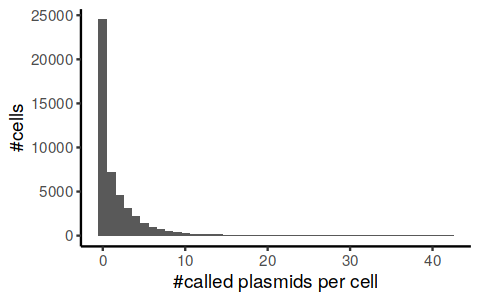

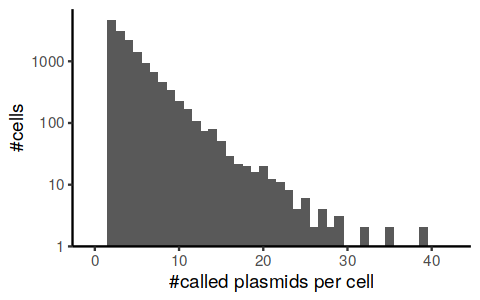

In [168]:
df_calls_all = seurat_combined@meta.data[, c('n_plasmids','n_guides')]

p5 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") + 
    theme_classic() 

p6 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    scale_y_log10(limits = c(1, 7000), expand = c(0, 0)) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic() 

options(repr.plot.width=4, repr.plot.height=2.5)
p5
p6

In [169]:
mean(df_calls_all$n_plasmids[df_calls_all$n_plasmids>0])
mean(df_calls_all$n_plasmids)
nrow(df_calls_all)

[1] 3.2

[1] 1.5

[1] 46051

### Plot cells per plasmid distribution

In [170]:
plasmid_calls = seurat_combined@meta.data$plasmid_calls
plasmid_calls = str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy = as.data.frame(table(plasmid_calls))
df_dummy$plasmid_calls = as.character(df_dummy$plasmid_calls)
df_dummy[df_dummy$plasmid_calls == "NA", 'plasmid_calls'] = " No Plasmid"

In [171]:
head(df_dummy, 20)

,plasmid_calls,Freq
,<chr>,<int>
1,BDKRB2-1,1039
2,C15orf40-1,526
3,CCCE1-1,522
4,CCCE2-1,463
5,CCCE3-1,368
6,CCCE4-1,241
7,CD13-1,564
8,CD55-1,466
9,CD73-1,474


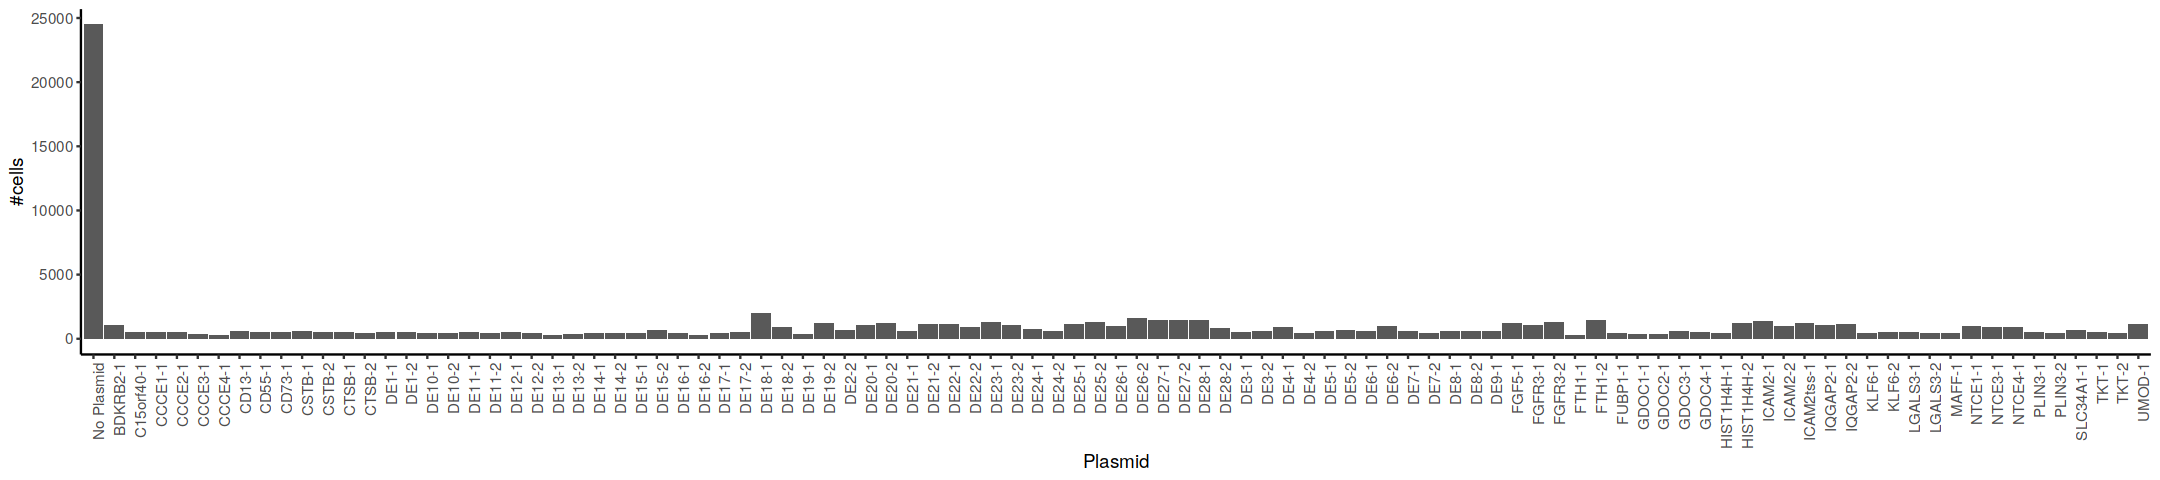

In [172]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

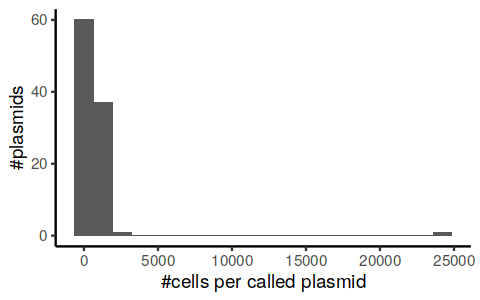

In [173]:
options(repr.plot.width=4, repr.plot.height=2.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    theme_classic() 
    

#### Eliminate no-call cells and plot again

In [174]:
df_dummy = df_dummy[df_dummy$plasmid_calls != " No Plasmid", ] 

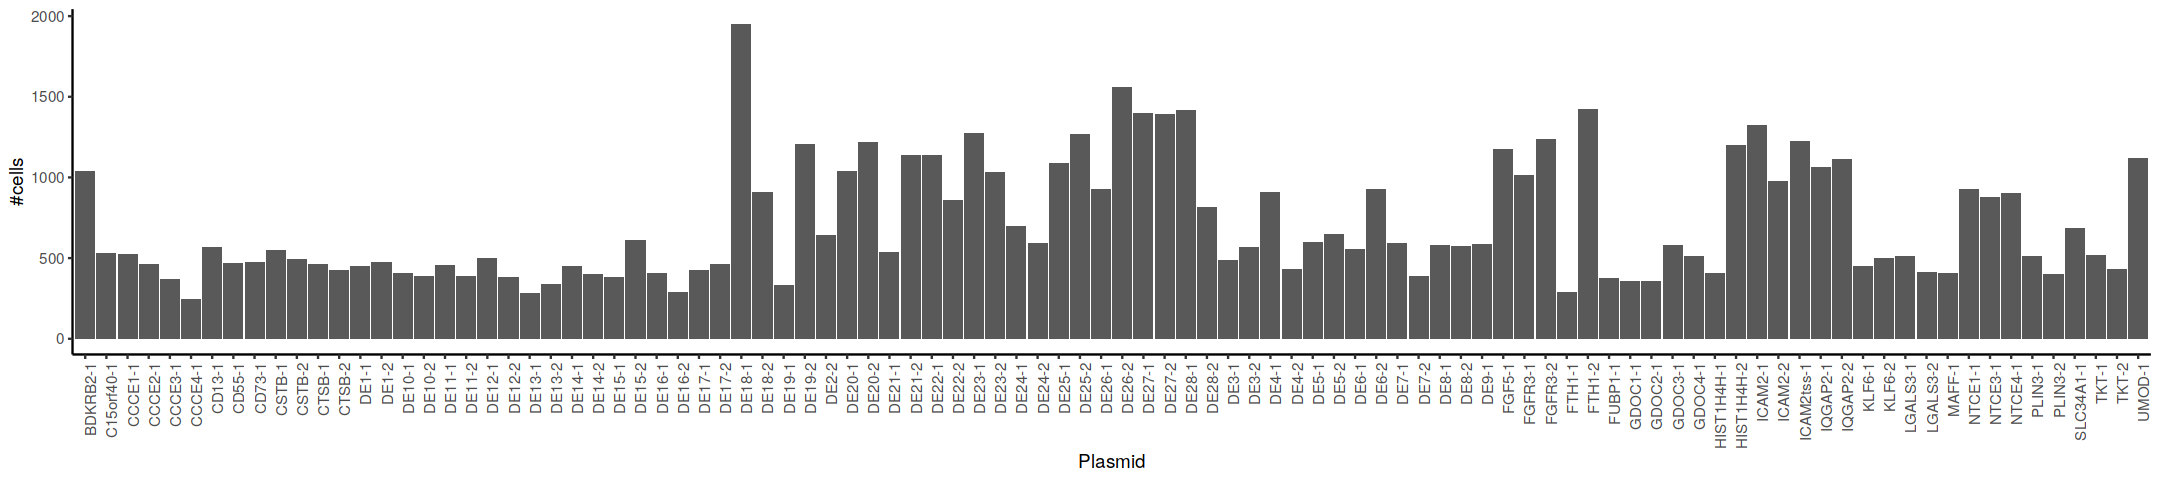

In [175]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


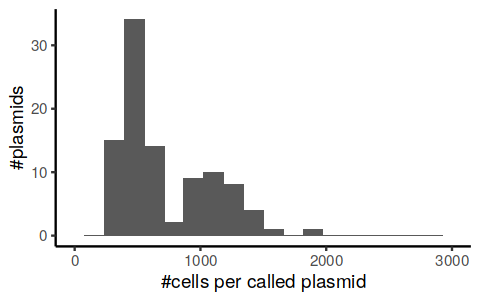

In [176]:
options(repr.plot.width=4, repr.plot.height=2.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    xlim(-1,3000) +
    theme_classic() 
    

In [177]:
length(Cells(subset(seurat_combined, subset=library=='Lib_2')))

[1] 5055

# Stats

In [178]:
df_stats = seurat_combined@misc$stats
df_stats


,Cells_after_QC_filtering,Cells_recovered,Cells_with_sgRNA_count_less_than_100,Doublets_in_filtered_cells,Genes_recovered,Library,Max_mito_perc_threshold,Max_n_RNA_threshold,Max_n_genes_threshold,Min_mito_perc_threshold,Min_n_RNA_threshold,Min_n_genes_threshold,Protospacers_in_assay,Screen,Singlets_after_filtering,Singlets_perc_after_filtering,Total_doublets_before_filtering
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>
Lib_1,4765,5627,2845,290,29979,Lib_1,27,63716,11034,3,-20142,2000,202,Screen2_101vecs,4475,0.94,407
Lib_2,5485,9597,3161,427,29397,Lib_2,27,42848,13036,3,-25292,2000,202,Screen2_101vecs,5055,0.92,651
Lib_3,6398,12681,3548,680,30647,Lib_3,27,57213,16144,3,-34679,2000,202,Screen2_101vecs,5717,0.89,1319
Lib_4,6109,12632,3339,774,30625,Lib_4,26,50879,14860,3,-30311,2000,202,Screen2_101vecs,5332,0.87,1572
Lib_5,5723,11565,2977,714,30653,Lib_5,26,60665,16665,3,-36591,2000,202,Screen2_101vecs,5007,0.87,1410
Lib_6,6188,10176,3274,836,28895,Lib_6,26,33994,9682,3,-19308,2000,202,Screen2_101vecs,5345,0.86,1184
Lib_7,5463,12699,3076,534,29718,Lib_7,24,27215,9938,3,-15911,2000,202,Screen2_101vecs,4927,0.90,1539
Lib_8,6134,12449,3371,705,29515,Lib_8,24,28537,10080,3,-16287,2000,202,Screen2_101vecs,5425,0.88,1496
Lib_9,4960,5516,4499,192,29387,Lib_9,14,37017,8336,3,-2026,2000,202,Screen2_101vecs,4768,0.96,246


# dCas9 - sgRNA count correlation

Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1063 rows containing missing values (`geom_point()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


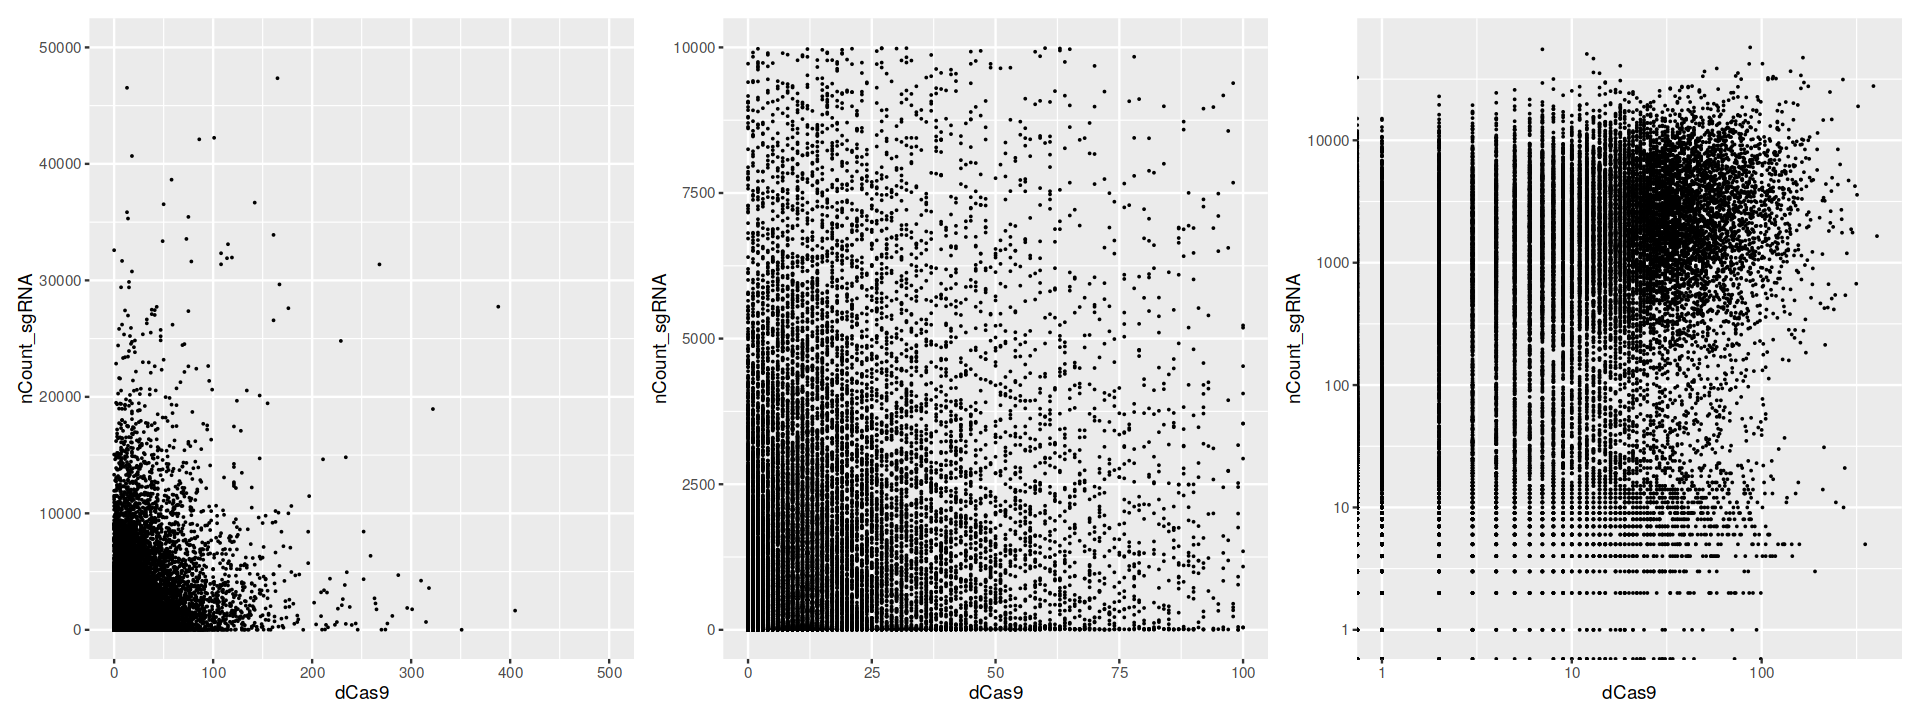

In [179]:
options(repr.plot.width=16, repr.plot.height=6)

ggplot(seurat_combined@meta.data, aes(x=dCas9, nCount_sgRNA)) +
    geom_point(size=0.01) +
    xlim(0,500) +
    ylim(0,50000) +

ggplot(seurat_combined@meta.data, aes(x=dCas9, nCount_sgRNA)) +
    geom_point(size=0.01) +
    xlim(0,100) +
    ylim(0,10000) +


ggplot(seurat_combined@meta.data, aes(x=dCas9, nCount_sgRNA)) +
    geom_point(size=0.01) +
    scale_y_log10() +
    scale_x_log10() 

In [180]:
cor(seurat$nCount_sgRNA, seurat$dCas9, method='pearson')
cor(seurat$nCount_sgRNA, seurat$dCas9, method='spearman')

[1] 0.1

[1] 0.12

## Check specific guides

# Debug

In [181]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [183]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined, df_thresholds)

In [182]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 905

[1] 905

In [184]:
length(perturbed_cells_by_guide$'DE6-1b')

[1] 425

In [185]:
nrow(seurat_combined)

[1] 30056

In [186]:
unique(seurat_combined$status)

[1] "singlet"

In [187]:
table(seurat_combined$library)


Lib_1 Lib_2 Lib_3 Lib_4 Lib_5 Lib_6 Lib_7 Lib_8 Lib_9 
 4475  5055  5717  5332  5007  5345  4927  5425  4768 

In [188]:
length(perturbed_cells_by_guide$'FTH1-1a')

[1] 203

In [189]:
length(unlist(perturbed_cells_by_guide))

[1] 96792

### ---

In [190]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined_debug    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
#seurat_combined_debug    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


In [191]:
libraries = unique(seurat_combined_debug$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined_debug, subset = library == lib)
}
names(seurat_libs) <- libraries

In [192]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined_debug, df_thresholds)

ERROR: Error in intI(i, n = d[1L], dn[[1L]], give.dn = FALSE): invalid character indexing


In [ ]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 905

[1] 905

In [ ]:
sum(rowSums(seurat_combined_debug[['sgRNA']]@counts)) - sum(rowSums(seurat_combined[['sgRNA']]@counts))

[1] 0

In [ ]:
colSums(seurat_combined_debug@meta.data != seurat_combined@meta.data)

nCount_RNA    nFeature_RNA    nCount_sgRNA  nFeature_sgRNA      nCount_SCT 
              0               0               0               0               0 
   nFeature_SCT      orig.ident         library      percent.mt          status 
              0               0               0               0               0 
          donor           dCas9 SCT_snn_res.0.5 seurat_clusters     guide_calls 
              0               0               0               0              NA 
  plasmid_calls        n_guides      n_plasmids 
             NA               0               0